# Backpack Kaggle Competition
### W207 Final Project - Spring 2025

Team: Perry Gabriel, Aurelia Yang

University of California, Berkeley

## Description

In this competition, participants are challenged to develop machine learning models to predict the price of a backpack based on various features. This is a great opportunity to test your skills, learn new techniques, and compete with others in the data science community.

## Evaluation

Submissions are evaluated on the root mean squared error between the predicted and actual price of the backpack.

RMSE is defined as:
$$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

where $y_i$ is the actual price of the backpack and $\hat{y}_i$ is the predicted price of the backpack.

## Data Description

The data consists of the following columns:

- `id`: A unique identifier for the backpack.
- `Brand`: The brand of the backpack.
- `Material`: The material of the backpack.
- `Size`: The size of the backpack.
- `Compartments`: The number of compartments in the backpack.
- `Laptop Compartment`: Whether the backpack has a laptop compartment.
- `Waterproof`: Whether the backpack is waterproof.
- `Style`: The style of the backpack.
- `Color`: The color of the backpack.
- `Weight Capacity (kg)`: The weight capacity of the backpack in kilograms.
- `Price`: The price of the backpack.

## Submission File

For each `id` in the test set, you must predict the price of the backpack. The file should contain a header and have the following format:

```csv
id,Price
1,100
2,200
3,300
```

## Timeline

- **Start Date** - February 1, 2025
- **Entry Deadline** - Same as the Final Submission Deadline
- **Team Merger Deadline** - Same as the Final Submission Deadline
- **Final Submission Deadline** - February 28, 2025

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

## Acknowledgements

This dataset was created by [Kaggle](https://www.kaggle.com/datasets/souradippal/student-bag-price-prediction-dataset) for the purpose of hosting a competition.

## Team Members

- [Perry Gabriel](https://www.kaggle.com/prgabriel)
- [Aurelia Yang](https://www.kaggle.com/aureliayang)

## Sections

1. [Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)
2. [Data Preprocessing](#2.-Data-Preprocessing)
3. [Modeling](#3.-Modeling)
4. [Evaluation](#4.-Evaluation)
5. [Optimization](#5.-Optimization)
6. [Final Submission](#6.-Final-Submission)
7. [Conclusion](#7.-Conclusion)


## 1. Exploratory Data Analysis

In this section, we will explore the data to understand its structure and identify any patterns or trends that may be present.


### 1.1 Load the Data

Let's start by loading the data and taking a look at the first few rows.

In [ ]:
!pip install -r ../requirements.txt

In [2]:
import os
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

In [3]:
raw_data_path = '../data/raw/'

In [4]:
%pip install google.colab

def check_and_import_colab():
    global raw_data_path
    global processed_path
    try:
        from google.colab import drive  
        import google.colab
        print("Running on Google Colab")
        # Import necessary libraries for Google Colab
        drive.mount('/content/drive')

        # define paths
        raw_data_path = "/content/drive/MyDrive/Kaggle_Backpack/data/raw/"
        processed_path = "/content/drive/MyDrive/Kaggle_Backpack/data/processed/"
        return True

    except ImportError:
        print("Not running on Google Colab")
        os.makedirs(raw_data_path, exist_ok=True)
        print("Created 'raw_data_path' directory for non-Colab Environment.")
        return False

on_colab = check_and_import_colab()

ERROR: Could not find a version that satisfies the requirement google.colab (from versions: none)
ERROR: No matching distribution found for google.colab
Note: you may need to restart the kernel to use updated packages.
Not running on Google Colab
Created 'raw_data_path' directory for non-Colab Environment.


Uncomment to download the data from Kaggle. This assumes you have the Kaggle API installed and configured.

In [5]:
# !kaggle competitions download -c playground-series-s5e2
# !unzip playground-series-s5e2 -d ../data/raw/
# !pip install -r ../requirement.txt
# !rm -rf playground-series-s5e2.zip

In [6]:
mlflow.set_experiment(experiment_name='E2E_Kaggle_Backpack_Project')
mlflow.autolog()

2025/03/04 02:00:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/03/04 02:00:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


In [7]:
train_df = pd.read_csv(filepath_or_buffer=os.path.join(raw_data_path, 'train.csv'), index_col=0, header=0, sep=',')
test_df = pd.read_csv(filepath_or_buffer=os.path.join(raw_data_path, 'test.csv'), index_col=0, header=0, sep=',')
train_extra_df = pd.read_csv(filepath_or_buffer=os.path.join(raw_data_path, 'training_extra.csv'), index_col=0, header=0, sep=',')

train_df.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [8]:
test_df.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
id,,,,,,,,,
300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


In [9]:
train_extra_df.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
500000,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052,114.11068
500001,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095,129.74972
500002,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302,21.37370
500003,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581,48.09209
500004,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826,77.32461


### 1.2 Data Summary

Next, let's take a look at the summary statistics of the data.


In [10]:
# Display the summary statistics of the training data
train_df.describe()

,Compartments,Weight Capacity (kg),Price
count,300000.000000,299862.000000,300000.000000
mean,5.443590,18.029994,81.411107
std,2.890766,6.966914,39.039340
min,1.000000,5.000000,15.000000
25%,3.000000,12.097867,47.384620
50%,5.000000,18.068614,80.956120
75%,8.000000,24.002375,115.018160
max,10.000000,30.000000,150.000000


In [11]:
test_df.describe()

,Compartments,Weight Capacity (kg)
count,200000.000000,199923.000000
mean,5.442855,17.993033
std,2.888740,6.972079
min,1.000000,5.000000
25%,3.000000,12.068875
50%,5.000000,18.054750
75%,8.000000,23.965700
max,10.000000,30.000000


In [12]:
train_extra_df.describe()

,Compartments,Weight Capacity (kg),Price
count,3.694318e+06,3.692648e+06,3.694318e+06
mean,5.434022e+00,1.800883e+01,8.135820e+01
std,2.893227e+00,6.974541e+00,3.893050e+01
min,1.000000e+00,5.000000e+00,1.500000e+01
25%,3.000000e+00,1.206854e+01,4.747778e+01
50%,5.000000e+00,1.805243e+01,8.098592e+01
75%,8.000000e+00,2.398580e+01,1.148434e+02
max,1.000000e+01,3.000000e+01,1.500000e+02


Let's see the data types of each column.

In [13]:
print(f"Data types of columns in training dataset\n{train_df.dtypes}\n")
print(f"Data types of columns in training extra dataset\n{train_extra_df.dtypes}\n")
print(f"Data types of columns in testing dataset\n{test_df.dtypes}\n")

Data types of columns in training dataset
Brand                    object
Material                 object
Size                     object
Compartments            float64
Laptop Compartment       object
Waterproof               object
Style                    object
Color                    object
Weight Capacity (kg)    float64
Price                   float64
dtype: object

Data types of columns in training extra dataset
Brand                    object
Material                 object
Size                     object
Compartments            float64
Laptop Compartment       object
Waterproof               object
Style                    object
Color                    object
Weight Capacity (kg)    float64
Price                   float64
dtype: object

Data types of columns in testing dataset
Brand                    object
Material                 object
Size                     object
Compartments            float64
Laptop Compartment       object
Waterproof               object
Style  

Let's get the shape of the data.

In [14]:
# Display the shape of the dataset.
print(f"Shape of training data: {train_df.shape}")
print(f"Shape of training extra data: {train_extra_df.shape}")
print(f"Shape of testing data: {test_df.shape}")

Shape of training data: (300000, 10)
Shape of training extra data: (3694318, 10)
Shape of testing data: (200000, 9)


### 1.3 Data Visualization

We can also create visualizations to better understand the data.


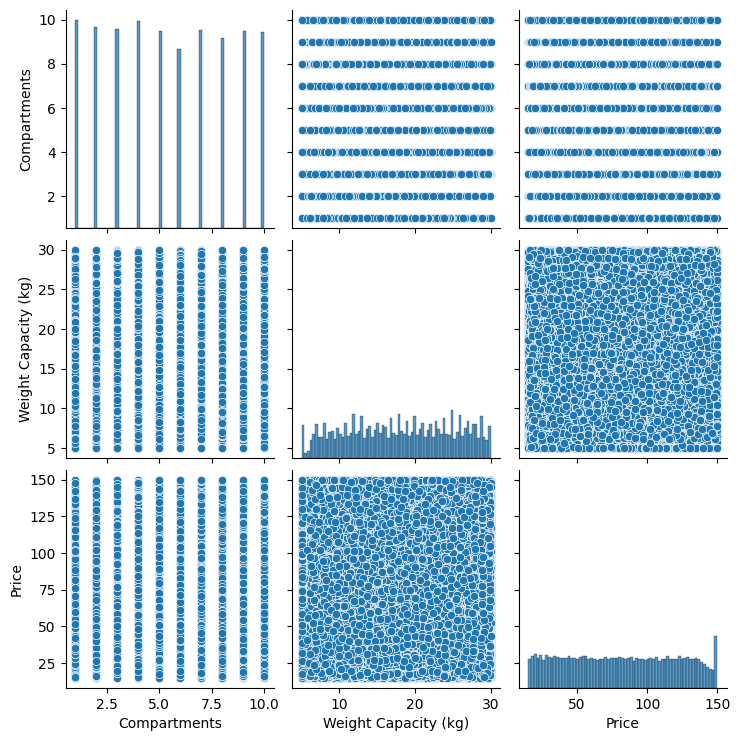

In [15]:
# Create a pairplot of the training data
sns.pairplot(train_df)
plt.show()

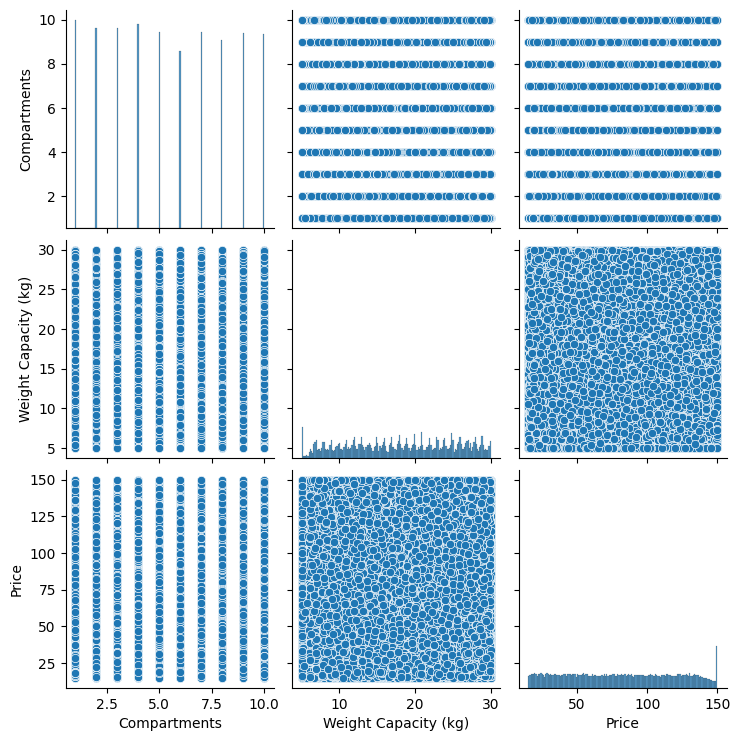

In [16]:
# Create a pairplot of the training extra data
sns.pairplot(train_extra_df)
plt.show()

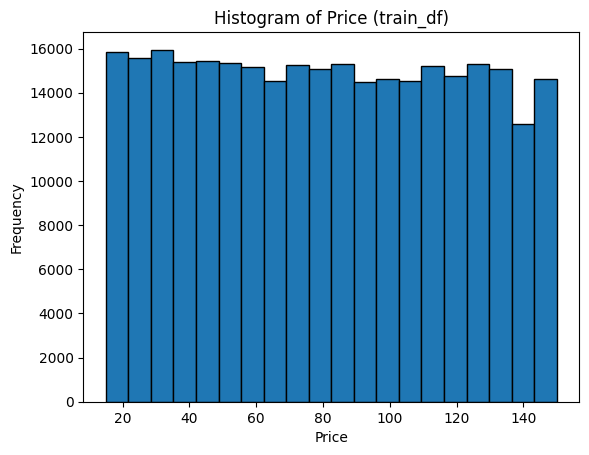

In [17]:
# For example, plot a histogram of the price column
plt.hist(train_df['Price'], bins=20, edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Price (train_df)')
plt.show()

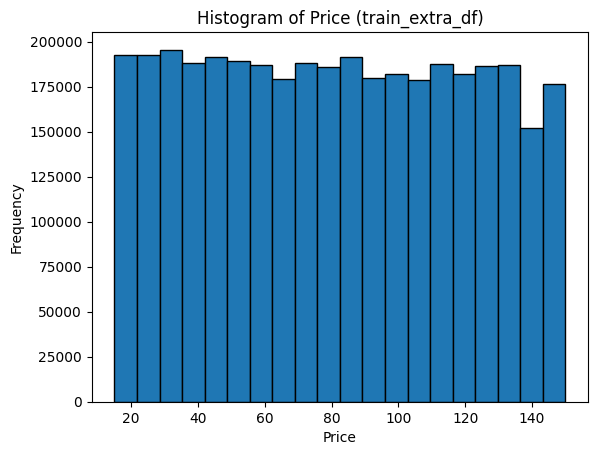

In [18]:
# For example, plot a histogram of the price column
plt.hist(train_extra_df['Price'], bins=20, edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Price (train_extra_df)')
plt.show()

### 1.4 Correlation Matrix

Finally, let's create a correlation matrix to see how the features are related to each other.


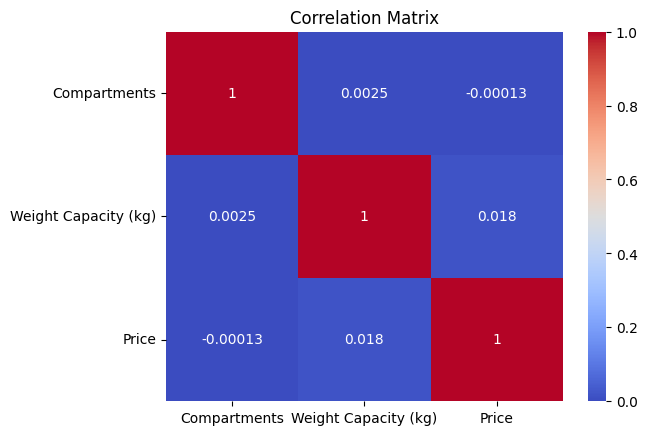

In [19]:
# Select only the numeric columns
numeric_cols = train_df.select_dtypes(include=['float64', 'int64'])

# Create a correlation matrix
corr = numeric_cols.corr()

# Display the correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Observations so far: 

- `training_extra` has significantly more records (3.69M) than `training` (300k), which will be useful in improving model training.
- Some categorical columns have substantial missing values:
    - `Brand`: 9705 missing in `train`, 117,000 missing in `train_extra`
    - `Material`, `Style`, `Color`
- `train_extra` has a higher proportion of missing values.
- Considering:
    - Mode imputation for categorical columns
    - Mean/median imputation for numerical columns


### 1.5 Feature Distribution

Let's take a look at the distribution of the features.

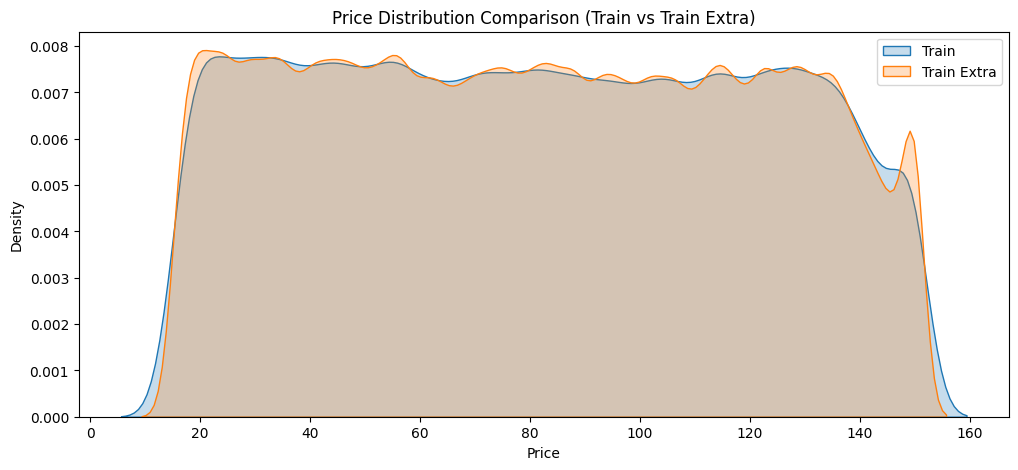

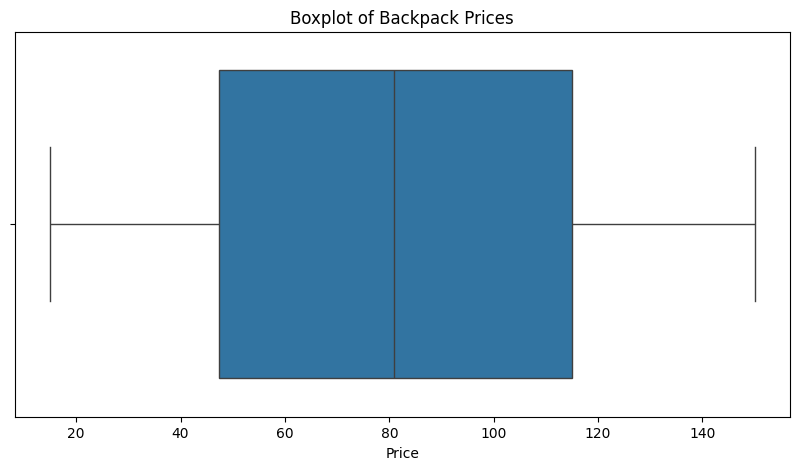

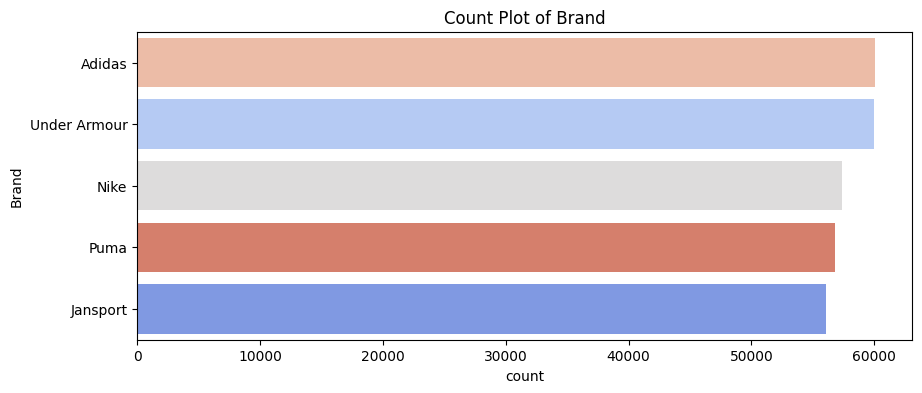

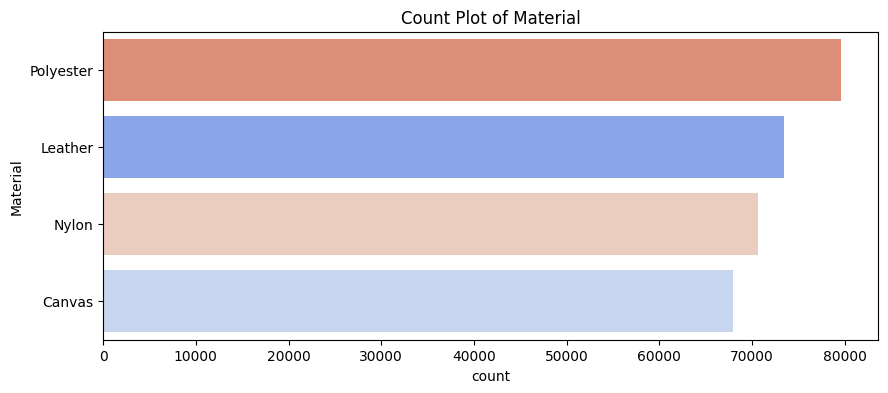

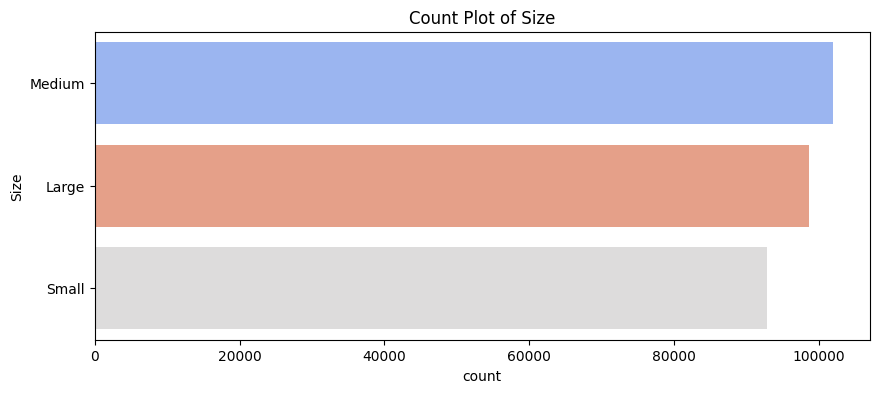

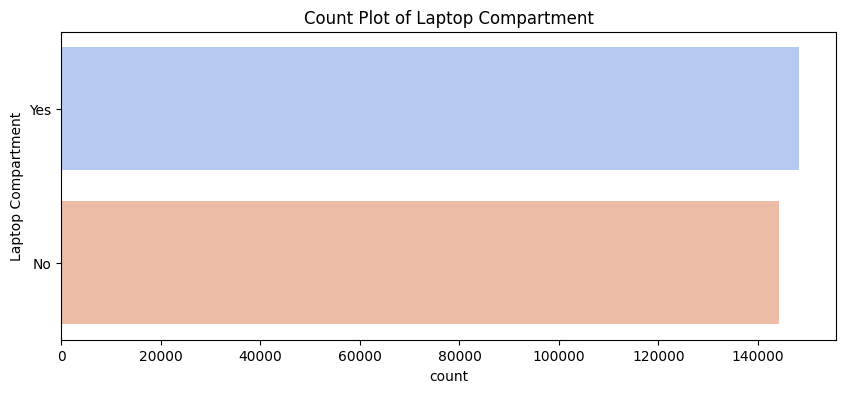

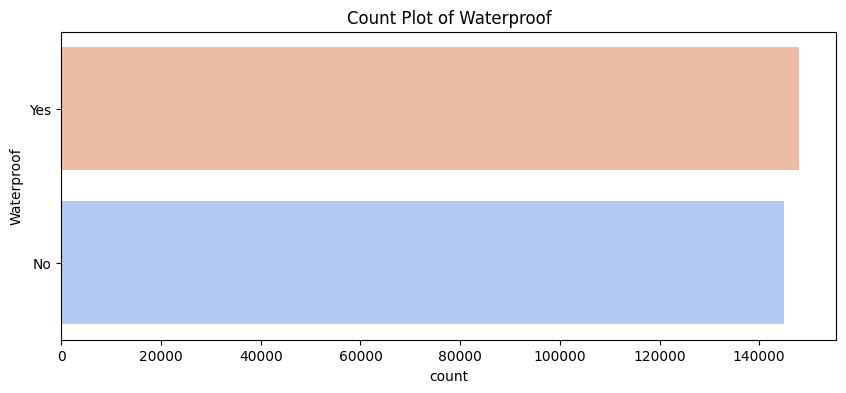

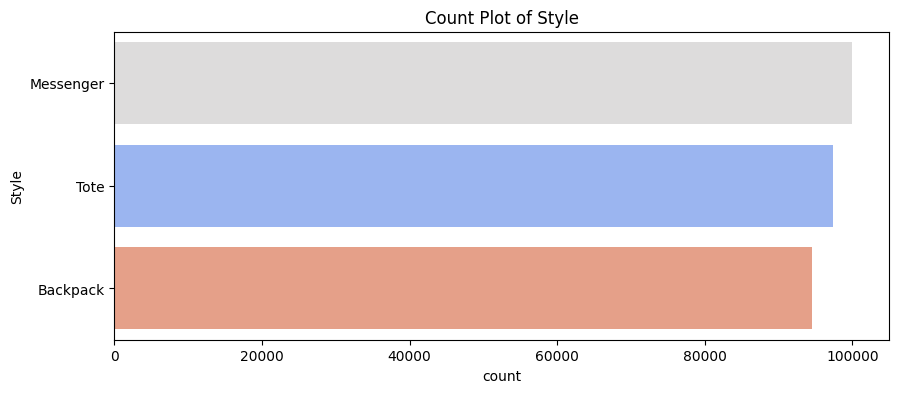

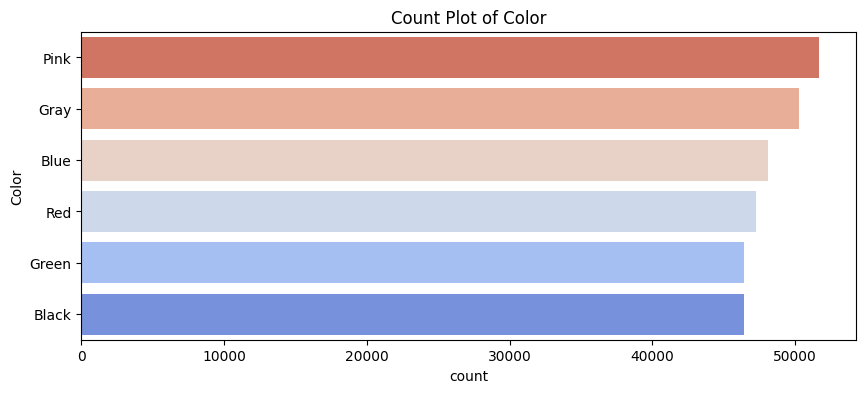

In [20]:
# define numerical and categorical cols
num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

# remove price
num_cols.remove('Price')

# feature distribution comparison train.csv vs train_extra.csv
plt.figure(figsize=(12, 5))
sns.kdeplot(train_df['Price'], label='Train', fill=True)
sns.kdeplot(train_extra_df['Price'], label='Train Extra', fill=True)
plt.legend()
plt.title("Price Distribution Comparison (Train vs Train Extra)")
plt.xlabel("Price")
plt.ylabel("Density")
plt.show()

# outlier boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(x=train_df["Price"])
plt.title("Boxplot of Backpack Prices")
plt.show()

# categorical feature distribution
for col in cat_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(y=train_df[col], order=train_df[col].value_counts().index, hue=train_df[col], palette="coolwarm", legend=False)
    plt.title(f"Count Plot of {col}")
    plt.show()


### Observations: Data Loading and Preprocessing

#### Price Distribution (train vs train extra)
- Both datasets are similarly distributed.

#### Outlier Analysis
- Slightly right-skewed distribution.
- Consider removing outliers?

#### Correlation Matrix
- Weight capacity is slightly positively correlated with price (0.2).
- Categorical feature impact on price needs boxplots by category -> build this out.

#### Categorical Feature Distribution
- No glaring abnormalities.

## 2. Data Preprocessing

In this section, we will preprocess the data to prepare it for modeling.

### 2.1 Missing Values

First, let's check for missing values in the data and decide how to handle them.

In [21]:
train_df.isnull().sum()

Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)     138
Price                      0
dtype: int64

In [22]:
train_extra_df.isnull().sum()


Brand                   117053
Material                102615
Size                     81190
Compartments                 0
Laptop Compartment       91089
Waterproof               87274
Style                    96210
Color                   123667
Weight Capacity (kg)      1670
Price                        0
dtype: int64

In [23]:
test_df.isnull().sum()

Brand                   6227
Material                5613
Size                    4381
Compartments               0
Laptop Compartment      4962
Waterproof              4811
Style                   5153
Color                   6785
Weight Capacity (kg)      77
dtype: int64

Let's fill in missing values categorical values with mode and numerical values with forward fill for both training datasets and test data.

In [24]:
# combine train and train_extra
train_combined = pd.concat([train_df, train_extra_df], axis=0).reset_index(drop=True)

# fill categorical with mode, others forward fill
for col in cat_cols:
    train_combined[col] = train_combined[col].fillna(train_combined[col].mode()[0])
test_df = test_df.ffill()

for col in num_cols:
    train_combined[col] = train_combined[col].fillna(train_combined[col].median())
test_df[num_cols] = test_df[num_cols].fillna(test_df[num_cols].median())

# one-hot encode (nominal categorical features)
ohe_cols = ['Brand', 'Color', 'Style']
train_encoded_df = pd.get_dummies(train_combined, columns=ohe_cols, drop_first=True)
test_encoded_df = pd.get_dummies(test_df, columns=ohe_cols, drop_first=True)

# ensure test set has same features as train
train_cols = train_encoded_df.columns
test_encoded_df = test_encoded_df.reindex(columns=train_cols, fill_value=0)

# ordinal feature label encoding
le_cols = ['Material', 'Size']
le = LabelEncoder()
for col in le_cols:
    train_encoded_df[col] = le.fit_transform(train_combined[col])
    test_encoded_df[col] = le.transform(test_df[col])


### 2.2 Feature Engineering

In this section, we will create new features that may help improve the performance of our models.


In [25]:
# feature engineering - interaction terms
train_encoded_df["Price_per_Compartment"] = train_encoded_df["Price"] / (train_encoded_df["Compartments"] + 1)
train_encoded_df["Has_Laptop_Compartment"] = train_encoded_df["Laptop Compartment"].apply(lambda x: 1 if x == "Yes" else 0)

# standardization (scale numerical features)
scaler = StandardScaler()
train_encoded_df[num_cols] = scaler.fit_transform(train_encoded_df[num_cols])
test_encoded_df[num_cols] = scaler.transform(test_encoded_df[num_cols])

In [26]:
# Check to see the changes
train_encoded_df.isnull().sum()


Material                  0
Size                      0
Compartments              0
Laptop Compartment        0
Waterproof                0
Weight Capacity (kg)      0
Price                     0
Brand_Jansport            0
Brand_Nike                0
Brand_Puma                0
Brand_Under Armour        0
Color_Blue                0
Color_Gray                0
Color_Green               0
Color_Pink                0
Color_Red                 0
Style_Messenger           0
Style_Tote                0
Price_per_Compartment     0
Has_Laptop_Compartment    0
dtype: int64

In [27]:
test_encoded_df.isnull().sum()

Material                0
Size                    0
Compartments            0
Laptop Compartment      0
Waterproof              0
Weight Capacity (kg)    0
Price                   0
Brand_Jansport          0
Brand_Nike              0
Brand_Puma              0
Brand_Under Armour      0
Color_Blue              0
Color_Gray              0
Color_Green             0
Color_Pink              0
Color_Red               0
Style_Messenger         0
Style_Tote              0
dtype: int64

Now, lets save the data to a new csv file under processed_data folder.

In [28]:
# Checks to see if this notebook is running on Google Colab and save to the recommended locations. 
if on_colab:
    # save processed data to drive
    train_encoded_df.to_csv(os.path.join(processed_path, "train_final.csv"), index=False)
    test_encoded_df.to_csv(os.path.join(processed_path, "test_final.csv"), index=False)
    print("Feature engineering completed - processed files saved on Google Drive.")
else:
    # Check if the directory exists, if not, create it
    processed_file_path = '../data/processed'
    if not os.path.exists(processed_file_path):
        os.makedirs(processed_file_path)

    # Save the transformed training data
    train_encoded_df.to_csv(processed_file_path + '/train_processed.csv', index=True)
    processed_train_encoded_df = train_encoded_df.copy()

    # Save the transformed testing data
    test_encoded_df.to_csv(processed_file_path + '/test_processed.csv', index=True)
    processed_test_encoded_df = test_encoded_df.copy()
    print("Feature engineering completed - processed files saved to Non-Colab Environment Local Drive.")

Feature engineering completed - processed files saved to Non-Colab Environment Local Drive.


### Observations so far ###
- Merged train and train_extra datasets
- Dropped id column
- OHE for brand, color and style
- Performed label encoding for material and size columns
- Added feature interactions
  - price_per_compartment, has_laptop_compartment
- mode imputation for categorical columns missing vals
- forward fill for numerical columns missing vals
- saved processed data to processed_data folder

## 3. Modeling

In this section, we will select and train machine learning models to predict the price of the backpack.


In [29]:
if on_colab:
    train_final_df = pd.read_csv(os.path.join(processed_path, "train_final.csv"))
    test_final_df = pd.read_csv(os.path.join(processed_path, "test_final.csv"))

    print("Train Final Shape:", train_final_df.shape)
    print("Test Final Shape:", test_final_df.shape)

    display(train_final_df.head(3))
    display(test_final_df.head(3))
else:
    train_final_df = pd.read_csv(os.path.join(processed_file_path, "train_processed.csv"))
    test_final_df = pd.read_csv(os.path.join(processed_file_path, "test_processed.csv"))

    print("Train Final Shape:", train_final_df.shape)
    print("Test Final Shape:", test_final_df.shape)

    display(train_final_df.head())
    display(test_final_df.head())

Train Final Shape: (3994318, 21)
Test Final Shape: (200000, 19)


,Unnamed: 0,Material,Size,Compartments,Laptop Compartment,Waterproof,Weight Capacity (kg),Price,Brand_Jansport,Brand_Nike,...,Brand_Under Armour,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red,Style_Messenger,Style_Tote,Price_per_Compartment,Has_Laptop_Compartment
0,0,1,1,0.541043,Yes,No,-0.917722,112.15875,True,False,...,False,False,False,False,False,False,False,True,14.019844,1
1,1,0,2,1.578013,Yes,Yes,1.300573,68.88056,True,False,...,False,False,False,True,False,False,True,False,6.261869,1
2,2,1,2,-1.187242,Yes,No,-0.196013,39.17320,False,False,...,True,False,False,False,False,True,True,False,13.057733,1
3,3,2,2,0.886700,Yes,No,-0.727615,80.60793,False,True,...,False,False,False,True,False,False,True,False,8.956437,1
4,4,0,1,-1.532898,Yes,Yes,-0.037447,86.02312,False,False,...,False,False,False,True,False,False,True,False,43.011560,1


,id,Material,Size,Compartments,Laptop Compartment,Waterproof,Weight Capacity (kg),Price,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red,Style_Messenger,Style_Tote
0,300000,1,2,-1.187242,No,No,0.381607,0,False,False,True,False,False,False,True,False,False,False,True
1,300001,0,1,0.541043,No,Yes,-0.637706,0,False,True,False,False,False,False,True,False,False,False,False
2,300002,0,0,1.232357,No,Yes,-0.889313,0,False,False,False,False,True,False,False,False,False,True,False
3,300003,2,0,-1.532898,Yes,No,0.066921,0,False,False,False,False,False,False,True,False,False,True,False
4,300004,2,0,-1.187242,Yes,Yes,-1.162081,0,False,False,False,False,False,False,False,False,False,False,True


In [30]:
# Drop the 'id' and 'Unnamed: 0' columns from the datasets
train_final_df.drop(columns=['Unnamed: 0'], inplace=True)
test_final_df.drop(columns=['id'], inplace=True)

# Verify the changes
print(train_final_df.head())
print(test_final_df.head())

   Material  Size  Compartments Laptop Compartment Waterproof  \
0         1     1      0.541043                Yes         No   
1         0     2      1.578013                Yes        Yes   
2         1     2     -1.187242                Yes         No   
3         2     2      0.886700                Yes         No   
4         0     1     -1.532898                Yes        Yes   

   Weight Capacity (kg)      Price  Brand_Jansport  Brand_Nike  Brand_Puma  \
0             -0.917722  112.15875            True       False       False   
1              1.300573   68.88056            True       False       False   
2             -0.196013   39.17320           False       False       False   
3             -0.727615   80.60793           False        True       False   
4             -0.037447   86.02312           False       False       False   

   Brand_Under Armour  Color_Blue  Color_Gray  Color_Green  Color_Pink  \
0               False       False       False        False       F

In [31]:
train_final_df.columns

Index(['Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof',
       'Weight Capacity (kg)', 'Price', 'Brand_Jansport', 'Brand_Nike',
       'Brand_Puma', 'Brand_Under Armour', 'Color_Blue', 'Color_Gray',
       'Color_Green', 'Color_Pink', 'Color_Red', 'Style_Messenger',
       'Style_Tote', 'Price_per_Compartment', 'Has_Laptop_Compartment'],
      dtype='object')

In [32]:
# Ensure 'Price' column is present before dropping
if 'Price' in train_final_df.columns:
	# Select the target feature
	y = train_final_df['Price']

	# Drop the target feature from the training dataframe
	X = train_final_df.drop(columns=['Price'])

	# Verify the changes
	print(X.head())
	print(y.head())
else:
	print("'Price' column is not present in train_final_df")

   Material  Size  Compartments Laptop Compartment Waterproof  \
0         1     1      0.541043                Yes         No   
1         0     2      1.578013                Yes        Yes   
2         1     2     -1.187242                Yes         No   
3         2     2      0.886700                Yes         No   
4         0     1     -1.532898                Yes        Yes   

   Weight Capacity (kg)  Brand_Jansport  Brand_Nike  Brand_Puma  \
0             -0.917722            True       False       False   
1              1.300573            True       False       False   
2             -0.196013           False       False       False   
3             -0.727615           False        True       False   
4             -0.037447           False       False       False   

   Brand_Under Armour  Color_Blue  Color_Gray  Color_Green  Color_Pink  \
0               False       False       False        False       False   
1               False       False       False         True

In [33]:
# Check the shape of X, and y
print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (3994318, 19)
y Shape: (3994318,)


In [34]:
# leftover cat cols
obj_cols = X.select_dtypes(include=['object']).columns
print("Object columns:", obj_cols)

Object columns: Index(['Laptop Compartment', 'Waterproof'], dtype='object')


### 3.1 Train-Test Split

First, let's split the data into training and testing sets.

In [35]:
# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# convert cat to numerical
X_train["Laptop Compartment"] = X_train["Laptop Compartment"].map({"Yes": 1, "No": 0})
X_train["Waterproof"] = X_train["Waterproof"].map({"Yes": 1, "No": 0})
X_val["Laptop Compartment"] = X_val["Laptop Compartment"].map({"Yes": 1, "No": 0})
X_val["Waterproof"] = X_val["Waterproof"].map({"Yes": 1, "No": 0})


### 3.2 Model Selection

Next, let's select a model to train on the data.

In [36]:
# baseline model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

lr_model = LinearRegression().fit(X_train, y_train)
lr_model

2025/03/04 02:02:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fa6d0292ceb7453c9fcbf3a4a1931f09', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


LinearRegression()

## 4. Evaluation

In this section, we will evaluate the performance of our models using various metrics.


In [37]:
# Generate our y_hat value with y_pred_lr variable.
y_pred_lr = lr_model.predict(X_val)

rmse_lr = root_mean_squared_error(y_val, y_pred_lr)
print("Baseline Linear Regression RMSE:", rmse_lr)

Baseline Linear Regression RMSE: 25.030691745558087


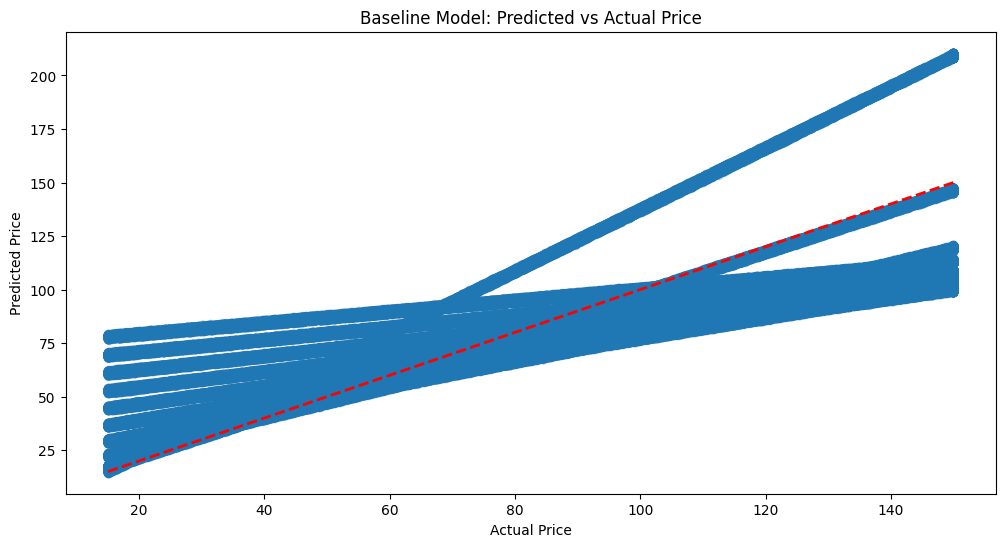

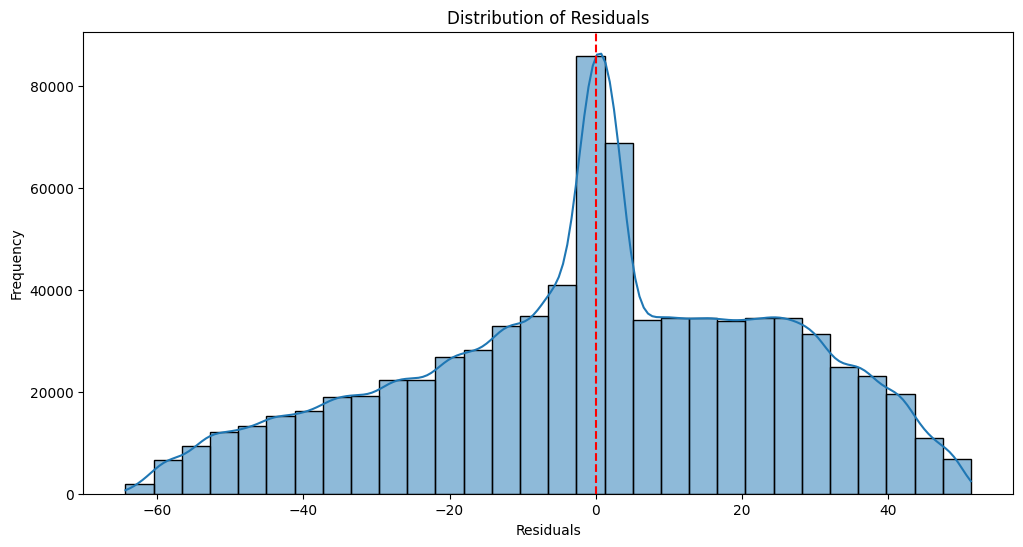

In [38]:
# Calculate residuals
residuals = y_val - y_pred_lr

# Plot baseline and residuals
plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_pred_lr, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Baseline Model: Predicted vs Actual Price')
plt.show()

# Plot distribution of residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

### Observations

#### Residual Distribution
- There is a large spike near residual = 0, indicating that, on average, the baseline model predictions are close to the actual price for many backpacks.
- Wide spread, heavy tails: Residuals extend from about -60 to +60, suggesting that for some backpacks, the baseline model underpredicts by up to 60 units and overpredicts by up to 60 units. A high variance in residuals suggests significant differences in how well the linear baseline model captures the data across different price ranges/categories.
- RMSE is very high: 25.03. While many predictions cluster around 0, there is still a lot of deviation.

#### Predicted vs Actual Price
- Points spread out well above and below the diagonal, meaning the baseline model error is not constant across the price range. The baseline model may overestimate some backpack prices (points above the red line) and underestimate others (points below the red line).
- There are multiple lines in the predicted values, indicating that the linear baseline model is grouping certain types of backpacks (perhaps by brand, color, or other splits) and producing similar predictions for them. This effect is more pronounced in linear baseline models when strong interactions are not fully captured.

#### Overall
- The baseline captures some positive relationship, but there is significant variance in the predictions with clear clusters at certain price ranges. The high error spread suggests the relationship cannot be captured by a simple linear baseline model and certain features may be missing.
- The multiple lines indicate that combining certain features leads to the same predicted price, so we may explore adding more interaction terms or exploring a non-linear baseline model next, such as a random forest.



## 5. Model Optimization

In this section, we will optimize the hyperparameters of our models to improve their performance.


## 6. Final Submission

In this section, we will select the best model and make final predictions on the test set.


## 7. Conclusion

In this section, we will summarize our findings and discuss the implications of our results.